<a href="https://colab.research.google.com/github/dorzv/ComputerVision/blob/master/vision_transformer/ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Build ViT-Base model

This code implements the ViT-Base model based on the Transformer architecture. The code is based on the paper ["AN IMAGE IS WORTH 16X16 WORDS: TRANSFORMERS FOR IMAGE RECOGNITION AT SCALE"](https://arxiv.org/pdf/2010.11929.pdf) and the aritcle [PyTorch Paper Replicating](https://https://www.learnpytorch.io/08_pytorch_paper_replicating)

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [ ]:
! pip install -q torchinfo
import torchinfo

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
import os
import zipfile
import requests 

def download_data(source_link, destination_folder, remove_zip=True):
  """
  A function to get a zip of data from a web, download it and unzip it into a
  folder. Can remove the zip after extraction.

  Args:
    source_link (str): a limk to the zip file.
    destination_folder (str): the name of the folder where the zip will be 
      extracted.
    remove_zip (bool): whether to remove the zip after extraction or not. 
      Default is True.
  
  Return:
    (str): path to the destination folder
  """

  image_path = os.path.join('data', destination_folder)
  target_path = os.path.join('data', os.path.basename(source_link))
  if os.path.isdir(image_path):
    print('Folder is already exists. Skipping donwload')
    return image_path
  
  # Download zip
  os.makedirs(image_path)
  with open(target_path, 'wb') as file:
    request = requests.get(source_link)
    print('Downloading zip file...')
    file.write(request.content)
  
  with zipfile.ZipFile(target_path, 'r') as zip_file:
    print('Unzipping...')
    zip_file.extractall(image_path)

  if remove_zip:
    os.remove(target_path)
  
  return image_path



In [ ]:
image_folder = download_data("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", "pizza_steak_sushi")
train_data_path = os.path.join(image_folder, 'train')
test_data_path = os.path.join(image_folder, 'test')


Unzipping...


In [ ]:
transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
# create Datasets
train_dataset = ImageFolder(train_data_path, transformation)
test_dataset = ImageFolder(test_data_path, transformation)

classes_name = train_dataset.classes

In [ ]:
# create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, 
                              num_workers=os.cpu_count(), pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                             num_workers=os.cpu_count(), pin_memory=True)

image size = torch.Size([3, 224, 224]), label = 1


(-0.5, 223.5, 223.5, -0.5)

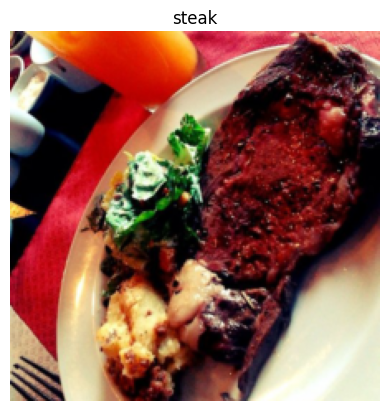

In [ ]:
# see an example of image
image_batch, label_batch = next(iter(train_dataloader))
image = image_batch[0]
label = label_batch[0]
print(f'image size = {image.shape}, label = {label}')
image_permute = image.permute(1, 2, 0)
plt.imshow(image_permute)
plt.title(classes_name[label])
plt.axis(False)

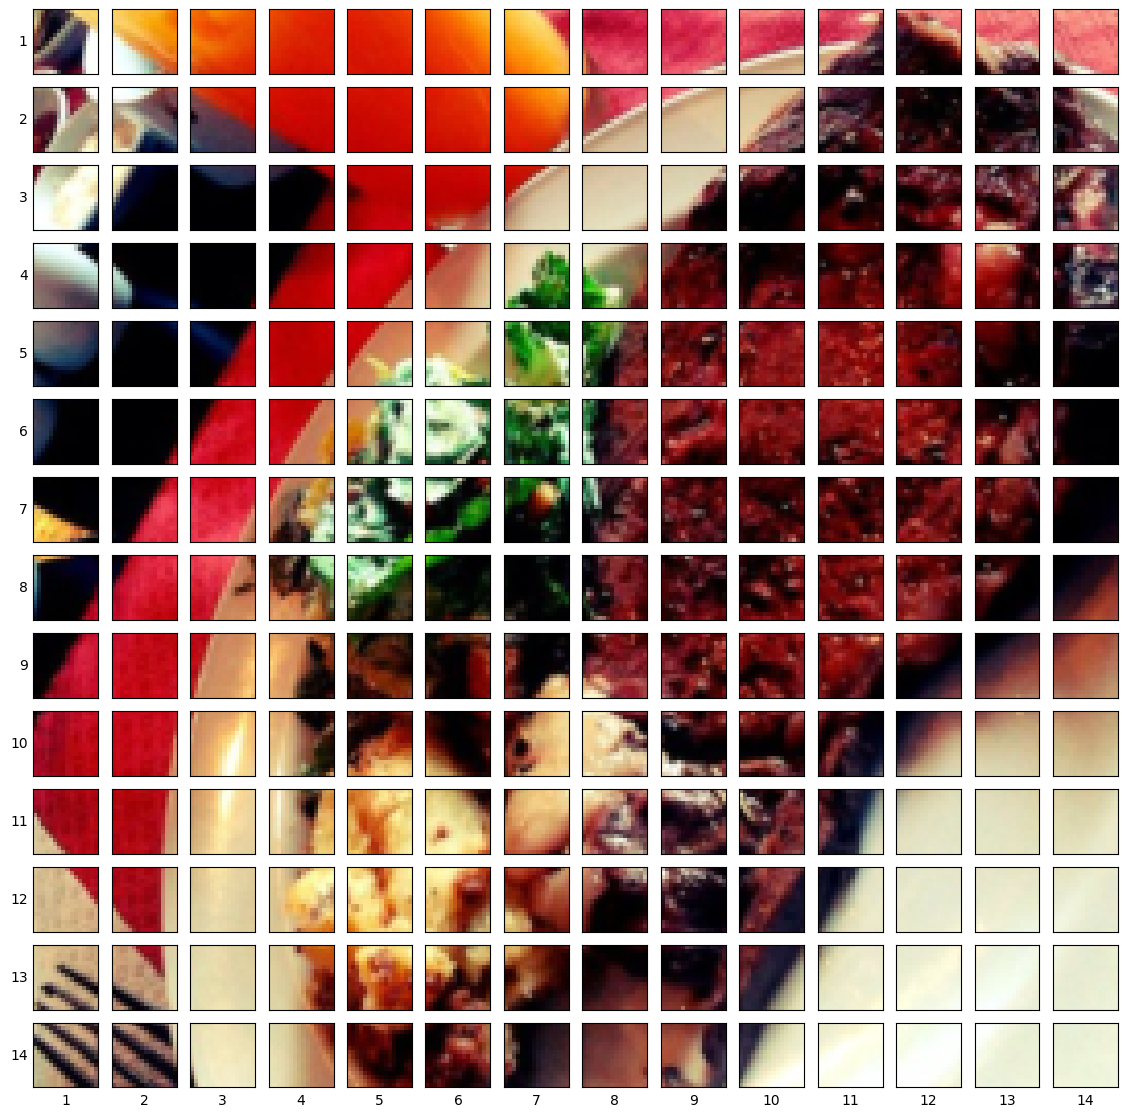

In [ ]:
# visualize image as patches
image_size = image_permute.shape[0]
patch_size = 16
num_of_patches = image_size // patch_size
if image_size % patch_size != 0:
  raise ValueError("Image size must be divisible by patch size")

fig, axes = plt.subplots(nrows=num_of_patches, ncols=num_of_patches, 
                       figsize=(num_of_patches, num_of_patches), sharex=True,
                       sharey=True)

# plot each patch in. a subplot
for ii, patch_height in enumerate(range(0, image_size, patch_size)):
  for jj, patch_width in enumerate(range(0, image_size, patch_size)):
    axes[ii, jj].imshow(image_permute[patch_height:patch_height+patch_size,
                                          patch_width:patch_width+patch_size,
                                          :])
    
    # set labels
    axes[ii, jj].set_ylabel(ii+1, rotation="horizontal",
                            horizontalalignment="right", 
                            verticalalignment="center") 
    axes[ii, jj].set_xlabel(jj+1)
    axes[ii, jj].set_xticks([])
    axes[ii, jj].set_yticks([])
    axes[ii, jj].label_outer()


In [ ]:
class PatchEmbedding(nn.Module):
  """
  Convert a 2D image into a squence of 1D vector of embedding represntation
  of patches on the image.
  
  Args:
    in_channel (int): the number of channels of the input image (default 3)
    patch_size (int): the size of each patch of the image (default 16)
    embedding_size (int): the size of the embedding vector (defualt 768)
  """
  def __init__(self, in_channels=3, patch_size=16, embedding_size=768):
    super().__init__()

    self.patch_size = patch_size

    self.patcher = nn.Conv2d(in_channels, embedding_size, patch_size, stride=patch_size)
    self.flatten = nn.Flatten(start_dim=2, end_dim=3)

  def forward(self, x):
    image_size = x.shape[-1]
    if image_size % self.patch_size != 0:
      raise ValueError(f'Patch size {self.patch_size} is not compatible with the image size {image_size}')
    
    x_patched = self.patcher(x)
    x_flatten = self.flatten(x_patched)

    return x_flatten.permute((0, 2, 1))


In [ ]:
# Add class token embedding and positional embedding to the patch embedding.
# The class token embedding is concatenated to the begginig of the patch embedding
# and the positional embedding is added to the prevous embedding, as in equation
# (1) in the paper
 
torch.manual_seed(42)
torch.cuda.manual_seed(42)

patch_size = 16
print(f'Image tensor shape is {image.shape}')
height, width = image.shape[1:3]

# Add batch dimension
x = image.unsqueeze(0)

patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_size=768)
patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape is {patch_embedding.shape}')

class_token = nn.Parameter(torch.randn(patch_embedding.shape[0], 1, patch_embedding.shape[-1]),
                          requires_grad=True)
print(f'Class token embedding shape is {class_token.shape}')

# Append the class token embedding to the patches embedding
patch_embedding_with_class_embedding = torch.cat((class_token, patch_embedding), dim=1)
print(f'Class token  embedding with patch embedding shape is {patch_embedding_with_class_embedding.shape}')

# Position embedding
position_embedding = nn.Parameter(torch.randn_like(patch_embedding_with_class_embedding),
                                  requires_grad=True)

# Add the position embedding to the patches embedding
patch_and_position_embedding = patch_embedding_with_class_embedding + position_embedding
print(f"Patch and position embedding shape is {patch_and_position_embedding.shape}")


Image tensor shape is torch.Size([3, 224, 224])
Patch embedding shape is torch.Size([1, 196, 768])
Class token embedding shape is torch.Size([1, 1, 768])
Class token  embedding with patch embedding shape is torch.Size([1, 1, 768])
Patch and position embedding shape is torch.Size([1, 197, 768])


In [ ]:
class MultiheadSelfAttentionBlock(nn.Module):
  """
  Create a multihead self attention block with layer normalization
  Args:
    embedding_dim (int): the hidden size - D
    num_heads (int): number of heads for the multihead self attention
    dropout (float): dropout probability 
  """

  def __init__(self, embedding_dim=768, num_heads=12, dropout=0):
      super().__init__()
      self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
      self.multihead_attention = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                       num_heads=num_heads,
                                                       dropout=dropout,
                                                       batch_first=True)
  
  def forward(self, x):
    x = self.layer_norm(x)
    attention_output, _ = self.multihead_attention(query=x, key=x, value=x, need_weights=False)

    return attention_output


In [ ]:
class MLPBlock(nn.Module):
  """
  Create a multilayer preceptron block with layer normalization

  Args:
    embedding_dim (int): the hidden size - D, used as input and output size
    mlp_size (int): the dimenstion of the hidden layer
    dropout (float): dropout probability 
  """

  def __init__(self, embedding_dim=768, mlp_size=3072, dropout=0.1):
    super().__init__()
    self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
    self.mlp = nn.Sequential(
        nn.Linear(embedding_dim, mlp_size),
        nn.GELU(),
        nn.Dropout(dropout),
        nn.Linear(mlp_size, embedding_dim),
        nn.Dropout(dropout)
    )

  def forward(self, x):
    x = self.layer_norm(x)
    x = self.mlp(x)
    return x

In [ ]:
class TransformerEncoderBlock(nn.Module):
  """
  Create the transformer encoder block

  Args:
    embedding_dim (int): the hidden size - D
    num_heads (int): number of heads for the multihead self attention
    mlp_size (int): the dimenstion of the hidden layer
    attention_dropout (float): dropout probability for the MSA 
    mlp_dropout (float): dropout probability for the MLP
  """

  def __init__(self, embedding_dim=768, num_heads=12, mlp_size=3072,
               attention_dropout=0, mlp_dropout=0.1):
    super().__init__()
    self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                 num_heads=num_heads,
                                                 dropout=attention_dropout)
    self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                               mlp_size=mlp_size,
                               dropout=mlp_dropout)
    
  def forward(self, x):
    x =  self.msa_block(x) + x 
    x = self.mlp_block(x) + x
    return x

In [ ]:
class ViT(nn.Module):
  """
  Create a Visuale Transformer. The defualt values of the hyperparameters are
  as of ViT-Base

  Args:
    img_size (int): image resolution. Default is 224 as in Table 3 in ViT paper
    in_channel (int): the number of channels of the input image. Default 3
    patch_size (int): the size (height and width) of the patch. Default 16
    num_transformer_layers (int): The number of transformers layers. Default is
      12 as in Table 1 in ViT paper for ViT base
    embedding_dim (int): hidden size D. Default is 768 as in Table 1 in ViT
      paper for ViT-Base
    mlp_size (int): MLP size. Default is 3072 as in Table 1 in ViT paper for ViT
      -Base
    num_heads (int): number of heads for the multihead self attention blocks.
      Default is 12 as in Table 1 in ViT paper for ViT-Base
    attention_dropout (float): dropout probability for the MSA block
    mlp_dropout (float): dropout probability for the MLP block
    embedding_dropout (float): dropout probability for patch and position
      embeddings
    num_classes (int): number of classes in the output. Default is 1000 as in 
      ImageNet
  """

  def __init__(self, 
               img_size=224,
               in_channels=3,
               patch_size=16,
               num_transformer_layers=12,
               embedding_dim=768, 
               mlp_size=3072,
               num_heads=12, 
               attention_dropout=0,
               mlp_dropout=0.1, 
               embedding_dropout=0.1,
               num_classes=1000):
    super().__init__()

    if img_size % patch_size != 0:
      raise ValueError(f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}.")

    self.num_patches = img_size ** 2 // patch_size ** 2
    
    # Create learnable class embedding (needs to go at front of sequence of patch embeddings)
    self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                        requires_grad=True)
    
    # Create learnable position embedding
    self.position_embedding = nn.Parameter(
        data=torch.randn(1, self.num_patches+1, embedding_dim),
        requires_grad=True)
    
    self.embedding_dropout = nn.Dropout(embedding_dropout)

    self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_size=embedding_dim)
    
    self.transformer_encoder = nn.Sequential(
        *[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                  num_heads=num_heads,
                                  mlp_size=mlp_size,
                                  mlp_dropout=mlp_dropout) 
         for _ in range(num_transformer_layers)]
         )
    
    self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, 
                      out_features=num_classes)
        )
    
  def forward(self, x):
    batch_size = x.shape[0]
    class_token = self.class_embedding.expand(batch_size, -1, -1)
    
    x = self.patch_embedding(x)
    x = torch.cat((class_token, x), dim=1)
    x = self.position_embedding + x
    x = self.embedding_dropout(x)
    x = self.transformer_encoder(x)
    x = self.classifier(x[:, 0])

    return x

In [ ]:
# initial the model and visualise it
from torchinfo import summary
vit = ViT(num_classes=len(classes_name))

# summary(model=vit, 
#         input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"]
# )

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [32, 3, 224, 224]    [32, 3]              152,064              True
├─PatchEmbedding (patch_embedding)                                [32, 3, 224, 224]    [32, 196, 768]       --                   True
│    └─Conv2d (patcher)                                           [32, 3, 224, 224]    [32, 768, 14, 14]    590,592              True
│    └─Flatten (flatten)                                          [32, 768, 14, 14]    [32, 768, 196]       --                   --
├─Dropout (embedding_dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
├─Sequential (transformer_encoder)                                [32, 197, 768]       [32, 197, 768]       --                   True
│    └─TransformerEncoderBlock (0)                           

In [ ]:
# train the model
optimizer = torch.optim.Adam(vit.parameters(), lr=3e-3, betas=(0.9, 0.999),
                             weight_decay=0.3)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 10

vit.to(device)

train_loss = []
train_acc = []
test_loss = []
test_acc = []

for epoch in range(epochs):
  vit.train()
  train_step_loss = 0
  train_step_acc = 0

  for batch_ii, (images_batch, labels_batch) in enumerate(train_dataloader):
    images_batch = images_batch.to(device)
    labels_batch = labels_batch.to(device)

    labels_predictions = vit(images_batch)
    loss = loss_fn(labels_predictions, labels_batch)
    train_step_loss += loss.item()
    train_step_acc += torch.sum(
        torch.argmax(labels_predictions, dim=1) == labels_batch
        ) / len(labels_batch)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_step_loss = train_step_loss / len(train_dataloader)
  train_step_acc = train_step_acc / len(train_dataloader)

  test_step_loss = 0
  test_step_acc = 0

  vit.eval()
  with torch.inference_mode():
    for batch_ii, (images_batch, labels_batch) in enumerate(test_dataloader):
      images_batch = images_batch.to(device)
      labels_batch = labels_batch.to(device)

      labels_predictions = vit(images_batch)
      loss = loss_fn(labels_predictions, labels_batch)
      test_step_loss += loss.item()
      test_step_acc += torch.sum(
        torch.argmax(labels_predictions, dim=1) == labels_batch
        ) / len(labels_batch)
    
  test_step_loss = test_step_loss / len(train_dataloader)
  test_step_acc = test_step_acc / len(test_dataloader)

  print(
  f"Epoch: {epoch+1} | "
  f"train_loss: {train_step_loss:.4f} | "
  f"train_accuracy: {train_step_acc:.4f} | "
  f"test_loss: {test_step_loss:.4f} | "
  f"test_accuracy: {test_step_acc:.4f}"
  )

  train_loss.append(train_step_loss)
  test_loss.append(test_step_loss)

Epoch: 1 | train_loss: 1.2786 | train_accuracy: 0.3281 | test_loss: 0.6015 | test_accuracy: 0.1979
Epoch: 2 | train_loss: 1.2926 | train_accuracy: 0.2812 | test_loss: 0.4509 | test_accuracy: 0.2604
Epoch: 3 | train_loss: 1.1034 | train_accuracy: 0.4062 | test_loss: 0.3816 | test_accuracy: 0.5417
Epoch: 4 | train_loss: 1.1318 | train_accuracy: 0.4062 | test_loss: 0.4454 | test_accuracy: 0.2604
Epoch: 5 | train_loss: 1.1880 | train_accuracy: 0.3047 | test_loss: 0.3960 | test_accuracy: 0.5417
Epoch: 6 | train_loss: 1.1656 | train_accuracy: 0.2812 | test_loss: 0.4109 | test_accuracy: 0.1979
Epoch: 7 | train_loss: 1.1219 | train_accuracy: 0.4219 | test_loss: 0.4937 | test_accuracy: 0.1979
Epoch: 8 | train_loss: 1.1143 | train_accuracy: 0.4141 | test_loss: 0.4256 | test_accuracy: 0.1979
Epoch: 9 | train_loss: 1.1270 | train_accuracy: 0.2930 | test_loss: 0.4229 | test_accuracy: 0.2604
Epoch: 10 | train_loss: 1.1384 | train_accuracy: 0.2891 | test_loss: 0.4131 | test_accuracy: 0.2604


Since the dataset is very small, it's reasonable that tha accuracy is small